# Lab1: Fine-tuning Large Transformer Models with Amazon SageMaker

### Distributed Sequence Classification with `Trainer` and the `clinc_oos` dataset

# Introduction

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow if you haven´t installed one of these frameworks._

In [2]:
%%capture
%pip install "sagemaker>=2.80.0" huggingface_hub --upgrade

In [1]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment, you need access to an IAM Role with the required permissions for Sagemaker. You can find more about it [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html)._

In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


## Creating an Estimator and starting a training job

List of supported models: https://huggingface.co/models?library=pytorch,transformers&sort=downloads

#### Pushing our model to the Hugging Face Hub

To push our model to the [Hugging Face Hub](https://huggingface.co/models), we need to use the `push_to_hub()` method of the `Trainer` in the `transformers` library. The `train.py` script that accompanies this notebook provides the relevant parameters to `TrainingArguments`, including the [Hugging Face Token](https://hf.co/settings/token) associated with your account, the repository name for the final model `hub_model_id`, and saving strategy `hub_strategy` to indicate how often to push a checkpoint to the Hub. 

You can find documentation for these parameters [here](https://huggingface.co/transformers/main_classes/trainer.html).

We are going to provide our HF Token securely with out exposing it to the public using the `notebook_login()` function from the `huggingface_hub` library. 
But be careful your token will still be visible inside the logs of the training job! If you run `huggingface_estimator.fit(...,wait=True)` you will see the token in the logs.
A better way of providing your `HF_TOKEN` to your training jobs would be using [AWS Secret Manager](https://docs.aws.amazon.com/secretsmanager/latest/userguide/intro.html)

#### You can also directly find your token at [https://hf.co/settings/token](https://hf.co/settings/token).


In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /home/ec2-user/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


after we logged in we can define our hyperparemter including the `model_id`. We are going to use [roberta-large](https://huggingface.co/roberta-large) as pre-trained model and the `SST2` dataset.

In [4]:
from sagemaker.huggingface import HuggingFace
from huggingface_hub import HfFolder
import time

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 5,                                                # number of training epochs
                 'train_batch_size': 16,                                     # batch size for training
                 'eval_batch_size': 16,                                      # batch size for evaluation
                 'learning_rate': 2e-5,                                      # learning rate used during training
                 'model_id':'roberta-large',                                 # pre-trained model
                 'dataset_id':'clinc_oos',                                        # dataset id 
                 'dataset_config':'plus',                                    # dataset configuration
                 'fp16': True,                                               # Whether to use 16-bit (mixed) precision training
                 'push_to_hub': True,                                        # Defines if we want to push the model to the hub
                 'hub_model_id': 'roberta-large-finetuned-clinc',            # The model id of the model to push to the hub
                 'hub_strategy': 'every_save',                               # The strategy to use when pushing the model to the hub
                 'hub_token': HfFolder.get_token()                           # HuggingFace token to have permission to push
                }

# configuration for running training on smdistributed Data Parallel
distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}

_if you don't want use the model hub as storage, you can just remove the `hub_token` and set `push_to_hub` to `False` then the model will be save to Amazon S3_

In [8]:
# define Training Job Name 
job_name = f'huggingface-workshop'

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # fine-tuning script used in training jon
    source_dir           = './scripts',       # directory where fine-tuning script is stored
    instance_type        = 'ml.p3.16xlarge',  # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    volume_size          = 300,               # increase size for storing artifacts
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    transformers_version = '4.17',            # the transformers version used in the training job
    pytorch_version      = '1.10',             # the pytorch_version version used in the training job
    py_version           = 'py38',            # the python version used in the training job
    hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
    distribution         = distribution,      # set up distributed training data parallelism
)

In [ ]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(wait=False)

Since we are using the Hugging Face Hub intergration with Tensorboard we can inspect our progress directly on the hub, as well as testing checkpoints during the training.

_comment out the cell below if you are not using the Hugging Face Hub_

In [10]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{hyperparameters['hub_model_id']}")

https://huggingface.co/lewtun/roberta-large-finetuned-clinc


## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [ ]:
predictor = huggingface_estimator.deploy(1,"ml.c5.xlarge")

Then, we use the returned predictor object to call the endpoint. We will send a few hundred requests with a sequence length of 128 to get a estimation of the latency.

In [84]:
sentiment_input= {"inputs": "Harry believes it, although no one else believes that Sally is innocent." * 9} # generates 128 seq length input

for i in range(200):
  predictor.predict(sentiment_input)

We can now take a look at cloudwatch to get our monitoring metrics. 

In [ ]:
print(f"https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'ModelLatency~'EndpointName~'{predictor.endpoint_name}~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT10M~end~'P0D~stat~'p99~period~300);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20{predictor.endpoint_name}")


Finally, we delete the inference endpoint.

In [86]:
predictor.delete_model
predictor.delete_endpoint()

# Create Performance chart

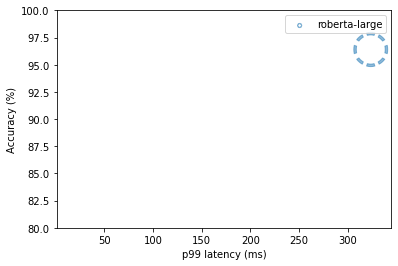

In [1]:
from visualize import plot_metrics
%matplotlib inline

metrics = {"roberta-large": {"time_p99_ms": 322, "accuracy": 0.9644,"size_mb":1322}}

plot_metrics(metrics, "roberta-large")